# Необходимо переключиться на среду выполнения с GPU


#Импорты и зависимости

In [1]:
!pip install -q torchmetrics[detection]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import datasets, models, transforms
import torchvision
from skimage.transform import resize
from torchvision.transforms import v2 as T
from torchvision.utils import save_image
from torch.utils.data import random_split
from torchvision.utils import draw_bounding_boxes

from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils
from torchvision.models.detection import SSD300_VGG16_Weights
from torchvision.ops import box_iou, complete_box_iou, complete_box_iou_loss

from torchmetrics.detection import MeanAveragePrecision
from torchmetrics.detection import IntersectionOverUnion

import sys
import os
from time import time
from skimage.io import imread
from matplotlib import rcParams
from PIL import Image
from google.colab import files
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 7.7 MB/s eta 0:00:00


Проверка девайса

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Загрузка данных

In [ ]:
!pip install xmltodict
import xmltodict

In [ ]:
files.upload() # Сюда необходимо загрузить свой собственный файл kaggle.json

Удобненько раскидываем все по каталогам

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d sbaghbidi/human-faces-object-detection
!unzip /content/human-faces-object-detection.zip
!rm /content/human-faces-object-detection.zip
!mkdir input
!mv images /content/input
!mv faces.csv /content/input

# Dataset и Dataloader

In [6]:
IMG_SIZE = 300
BATCH_SIZE = 8

In [8]:
# Ресайз + нормализация
transformer = transforms.Compose([transforms.ToTensor(),
                       transforms.Resize((IMG_SIZE, IMG_SIZE)),
                       transforms.Normalize([0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])

In [11]:
# Bounding boxes для изображений
annotations = pd.read_csv('/content/input/faces.csv')

In [12]:
annotations.head()

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


In [13]:
# Наследование класса Dataset для работы с нашими данными
class FacesDataset(torch.utils.data.Dataset):
    def __init__(self, root, ann, size, transform):
        self.root = root
        self.images = os.listdir(self.root)
        self.annotations = ann
        self.size = size
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.images[idx]))
        kx = self.size / img.size[0]
        ky = self.size / img.size[1]

        annotation_set = self.annotations.loc[self.annotations['image_name'] ==
                                              self.images[idx]]
        # Bounding boxes для каждого объекта
        # Формат: [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(len(list(annotation_set['image_name']))):
            xmin = list(annotation_set['x0'])[i]
            ymin = list(annotation_set['y0'])[i]
            xmax = list(annotation_set['x1'])[i]
            ymax = list(annotation_set['y1'])[i]

            width = xmax - xmin
            height = ymax - ymin
            x1 = xmin * kx
            y1 = ymin * ky
            w = width * kx
            h = height * ky

            boxes.append([x1, y1, x1 + w, y1 + h])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.tensor([1] * len(list(annotation_set['image_name'])))

        # Переводим аннотации в словарь
        new_annotation = {}
        new_annotation["boxes"] = boxes
        new_annotation["labels"] = labels

        return self.transform(img), new_annotation

    def __len__(self):
        return len(self.images)

In [14]:
photos = FacesDataset('/content/input/images/', annotations, IMG_SIZE, transformer)

In [16]:
# Разбиение данных на тренировочные, валидационные и тестовые
train_dataset, valid_dataset, test_dataset = random_split(photos, [0.7, 0.15, 0.15])

# Формирование Dataloader
dataset_list = {'train': train_dataset, 'val': valid_dataset}
dataloaders = {status: torch.utils.data.DataLoader(dataset_list[status],
                                             batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=2,
                                             collate_fn=lambda batch: tuple(zip(*batch)))
                                             for status in ['train', 'val']}

Смотрим на изображения и bounding boxes

In [17]:
def format_image(image):
  return (255.0 * (image - image.min()) /
         (image.max() - image.min())).to(torch.uint8)

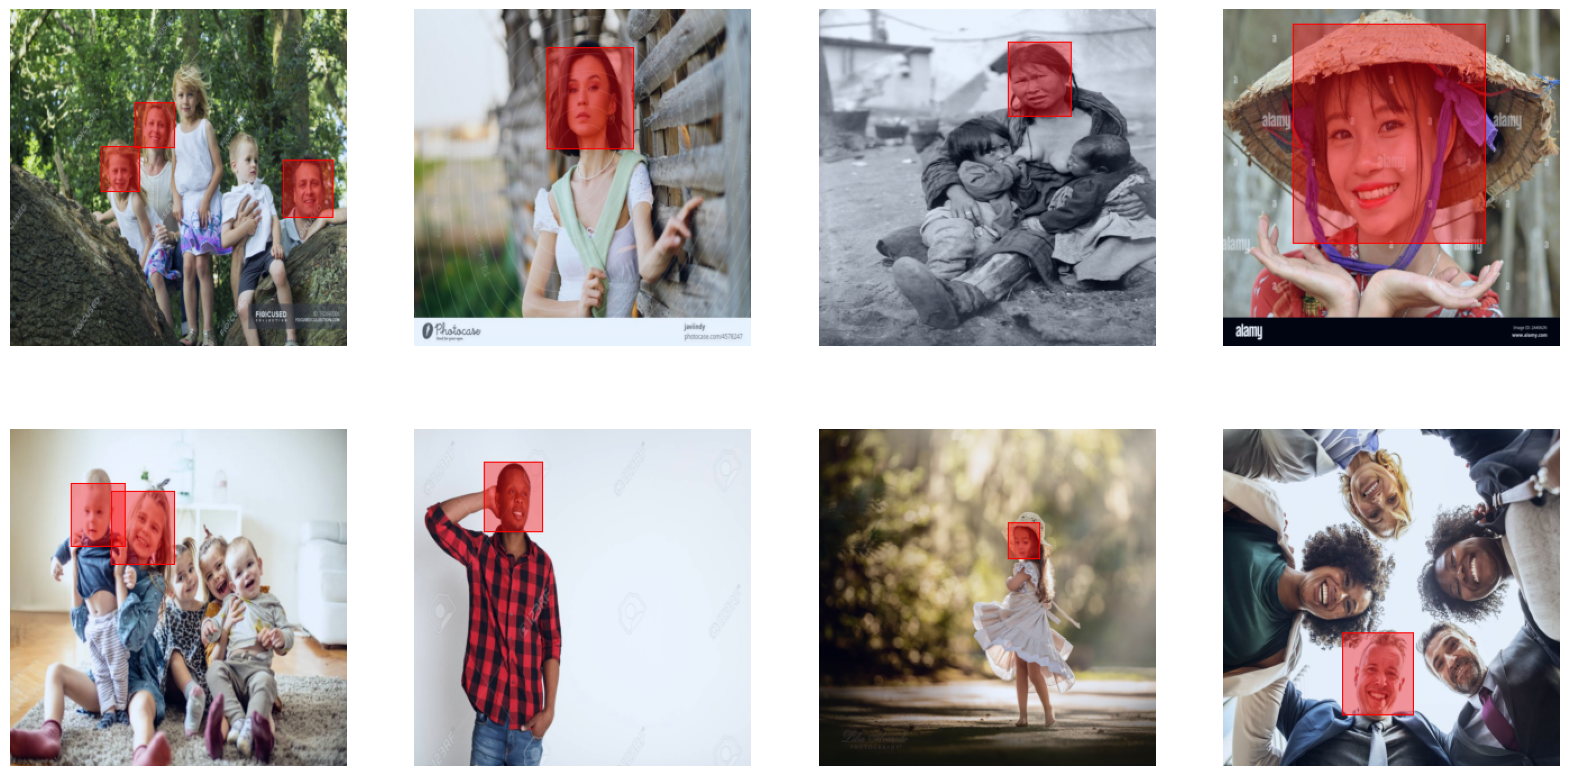

In [18]:
index = np.random.randint(0, len(photos), 8)
fig = plt.figure(figsize=(20,10))
for i in range(len(index)):
    fig.add_subplot(2, 4, i+1)
    data = photos[index[i]]
    look = data[0]

    # Отменяем нормализацию
    look = format_image(look)

    boxes = data[1]['boxes']
    result = draw_bounding_boxes(look, boxes,
                                 fill=True, width=1,
                                 colors=['red']*len(boxes)).permute(1, 2, 0)
    plt.axis("off")
    plt.imshow(result)
plt.show()

# Модель

Используем предобученную модель SSD с классификатором VGG16



score_thresh = .25 - порог для вероятноятности, при котором мы уверены, что объект найден.

In [ ]:
# Используем fine-tuning, возьмем архитектуру ssd с предобученным классификатором VGG16
ssd = models.detection.ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT,
                                    weights_backbone=models.VGG16_Weights,
                                    pretrained=True, score_thresh = .25)

In [ ]:
# Заменяем ClassificationHead модели
def create_model(model, num_classes=2, size=IMG_SIZE):
    in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
    num_anchors = model.anchor_generator.num_anchors_per_location()
    model.head.classification_head = SSDClassificationHead(
       in_channels=in_channels,
       num_anchors=num_anchors,
       num_classes=num_classes,
     )

    model.transform.min_size = (size,)
    model.transform.max_size = size
    return model

model = create_model(ssd)

In [ ]:
model

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

# Тренировка

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
num_epochs = 6

In [ ]:
model = model.to(device)

In [ ]:
train_itr = 1
val_itr = 1
def train(train_data_loader, model):
    model.train()
    print('--- Тренировка ---')
    global train_itr
    global train_loss_list

    # Прогресс бар обучения
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        # Основной код обучения
        optimizer.zero_grad()
        images, targets = data
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        current_loss = losses.item()
        train_loss_list.append(current_loss)
        losses.backward()
        optimizer.step()

        train_itr += 1

        # Апдейт прогресс бара
        prog_bar.set_description(desc=f"Loss: {current_loss:.4f}")
    return train_loss_list

In [ ]:
def validate(valid_data_loader, model):
    print('--- Валидация ---')
    global val_itr
    global val_loss_list

    # Прогресс бар
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
      images, targets = data
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

      with torch.no_grad():
        # Сичтаем лосс
        model.train()
        loss_dict = model(images, targets)
        metric = MeanAveragePrecision(iou_type="bbox")
        # Ситаем метрику MAP_50
        model.eval()
        output = model(images, targets)
        metric.update(output, targets)
        map_metric = metric.compute()['map_50']

      losses = sum(loss for loss in loss_dict.values())
      current_loss = losses.item()
      val_loss_list.append(current_loss)
      val_itr += 1

      # Апдейт прогресс бара
      prog_bar.set_description(desc=f"Loss: {current_loss:.3f}---mAP50: {map_metric:.3f}")
    return val_loss_list

In [ ]:
train_loss_list = []
val_loss_list = []

# Полный цикл обучения по эпохам
for epoch in range(num_epochs):
    print(f"\nEPOCH {epoch+1} of {num_epochs}")

    # Таймер
    start = time()
    train_loss = train(dataloaders['train'], model)
    val_loss = validate(dataloaders['val'], model)
    end = time()

    print(f"Epoch #{epoch + 1}")


EPOCH 1 of 6
--- Тренировка ---


  0%|          | 0/193 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Loss: 2.5666: 100%|██████████| 193/193 [01:32<00:00,  2.09it/s]


--- Валидация ---


Loss: 2.528---mAP50: 0.952: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


Epoch #1

EPOCH 2 of 6
--- Тренировка ---


Loss: 1.5715: 100%|██████████| 193/193 [01:21<00:00,  2.37it/s]


--- Валидация ---


Loss: 1.364---mAP50: 1.000: 100%|██████████| 42/42 [00:18<00:00,  2.21it/s]


Epoch #2

EPOCH 3 of 6
--- Тренировка ---


Loss: 1.7307: 100%|██████████| 193/193 [01:23<00:00,  2.32it/s]


--- Валидация ---


Loss: 1.897---mAP50: 1.000: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


Epoch #3

EPOCH 4 of 6
--- Тренировка ---


Loss: 1.6317: 100%|██████████| 193/193 [01:23<00:00,  2.30it/s]


--- Валидация ---


Loss: 1.397---mAP50: 1.000: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


Epoch #4

EPOCH 5 of 6
--- Тренировка ---


Loss: 2.4267: 100%|██████████| 193/193 [01:21<00:00,  2.36it/s]


--- Валидация ---


Loss: 2.167---mAP50: 1.000: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


Epoch #5

EPOCH 6 of 6
--- Тренировка ---


Loss: 1.1889: 100%|██████████| 193/193 [01:21<00:00,  2.36it/s]


--- Валидация ---


Loss: 1.641---mAP50: 1.000: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]


Epoch #6


Визуализируем процесс обучения

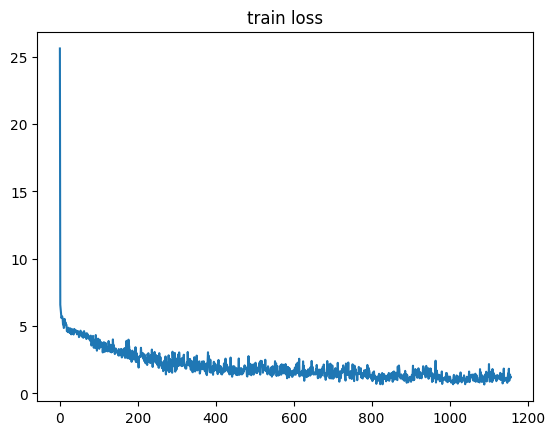

In [ ]:
plt.plot(train_loss)
plt.title('train loss')
plt.show()

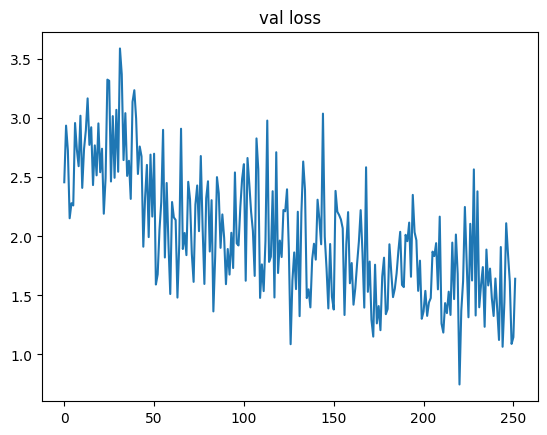

In [ ]:
plt.plot(val_loss)
plt.title('val loss')
plt.show()

# Визуализация работы

In [ ]:
def draw_bounding_boxes(input, model):
    image = input[0]
    with torch.no_grad():
        predictions = model.eval()([image.to(device),])
    pred = predictions[0]

    image = format_image(image)

    pred_label = [f"predicted face" for label in pred["labels"]]
    true_label = [f"true face" for label in input[1]["labels"]]
    pred_boxes = pred["boxes"].long()
    true_boxes = input[1]['boxes'].long()

    output_image = draw_bounding_boxes(image, pred_boxes, pred_label, fill=True,
                                       colors=['blue']*len(pred_label),
                                       width=1)
    output_image = draw_bounding_boxes(output_image, true_boxes, true_label,
                                       fill=False,
                                       colors=['red'] * len(true_label),
                                       width=1)

    targets = [{first: second.to(device) for first, second in curr.items()}
               for curr in [input[1],]]
    metric = MeanAveragePrecision(iou_type="bbox")
    metric.update(predictions, targets)

    map_50 = metric.compute()['map_50']
    iou = IntersectionOverUnion()(predictions, targets)

    return output_image, iou, map_50

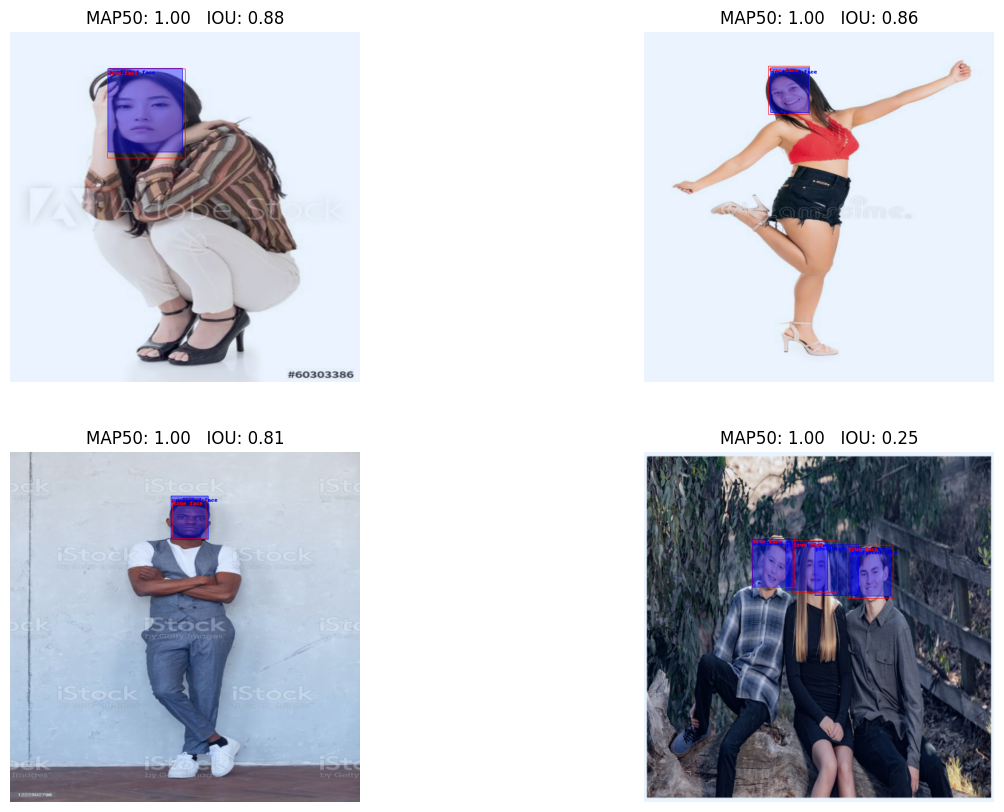

In [ ]:
index = np.random.randint(0, len(test_dataset), 4)
figure = plt.figure(figsize=(15,10))

for i in range(4):
    test = test_dataset[index[i]]
    look, IoU, MaP = draw_bounding_boxes(test, model)

    title = (f'MAP50: {MaP:.2f}   IOU: {IoU["iou"]:.2f}')
    figure.add_subplot(2, 2, i + 1).set_title(title)
    plt.imshow(look.permute(1, 2, 0))
    plt.axis("off")

plt.show()

Красные bounding boxes - из датасета


Синие - предсказанные моделью

# Сохранение модели

Формат pth

In [ ]:
torch.save(model.state_dict(), '/content/ssd.pth')

In [ ]:
# Проверяем корректность загрузки
params_path = os.path.join('/content/ssd.pth')
new_model = model
new_model.load_state_dict(torch.load(params_path))

Формат Caffee

In [ ]:
!pip install caffe2
!pip3 install pytorch2caffe

In [ ]:
from pytorch2caffe import pytorch2caffe

dummy_input = torch.randn(1, IMG_SIZE, IMG_SIZE, requires_grad=True)
pytorch2caffe.trans_net(model, dummy_input, "ssd")
pytorch2caffe.save_prototxt('{}.prototxt'.format("deploy"))
pytorch2caffe.save_caffemodel('{}.caffemodel'.format("ssd"))